# Final Project: 某闯关类手游用户流失预测

## 一、案例简介

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在毕业项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

## 二、作业说明

* 根据给出的实际数据（包括用户游玩历史，关卡特征等），预测测试集中的用户是否为流失用户（二分类）；
* 方法不限，自行进行评测，评价指标使用 AUC；
* 建议尝试使用云平台进行实验；
* 提交代码与实验报告，报告展示对数据的观察、分析、最后的解决方案以及不同尝试的对比等；
* 最终评分会参考达到的效果以及对所尝试方法的分析。

## 三、数据概览

本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### train.csv

训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [138]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./data/train.csv', sep='\t')

In [139]:
train_df

,user_id,label
0,2774,0
1,2775,0
2,2776,1
3,2777,0
4,2778,1
...,...,...
8153,10927,1
8154,10928,1
8155,10929,0
8156,10930,1


In [140]:
train_df['label'].value_counts()

label
0    5428
1    2730
Name: count, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

### dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [141]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### test.csv
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [142]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [143]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [144]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


auc需达到0.65以上

## 四、Tips

* 一个基本的思路可以是：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；
* 还可以借助其他模型（如循环神经网络）直接对用户历史序列建模；
* 数据量太大运行时间过长的话，可以先在一个采样的小训练集上调参；
* 集成多种模型往往能达到更优的效果；
* 可以使用各种开源工具。

## 五、云平台使用简介

- 腾讯云的TI-ONE平台
- 启动notebook并使用

## 六、实验过程

### 6.1、数据处理


#### level_seq.csv

这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

#### level_meta.csv

每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

#### 根据游玩关卡的记录为每个用户提取特征

将每个用户按照特征聚合为一条记录，从直觉上查找几个特征来描述用户画像，达不到标准再继续找。
- 是否感兴趣
  - 登录天数
  - 登录次数
  - 关卡总时长
  - 最后一天玩的局数
  - 最后一天玩的总时长
  - 尝试次数
- 用户游戏能力
  - 最大重试次数
  - 平均通关时长-平均时长
  - 平均剩余步数/限定步数
  - 通关树/总尝试次数
  - 最大闯关数
  - 最后10局通关率
  - 最后3局通关率

In [145]:
try_times = seq_df.groupby('user_id')['f_success'].count().fillna(1)
pass_times = seq_df.groupby('user_id')['f_success'].sum().fillna(0).rename('pass_times')
pass_rate = (pass_times / try_times).rename('pass_rate')
pass_rate

user_id
1        0.263291
2        0.514768
3        0.608696
4        0.532710
5        0.420168
           ...   
13585    0.451613
13586    0.446945
13587    0.700000
13588    0.964286
13589    0.809524
Name: pass_rate, Length: 13589, dtype: float64

In [146]:
# 时间戳按照年月日时分秒切分
seq_df['timestamp'] = pd.to_datetime(seq_df['time'])
seq_df['date'] = seq_df['timestamp'].dt.date
seq_df['year'] = seq_df['timestamp'].dt.year
seq_df['month'] = seq_df['timestamp'].dt.month
seq_df['day'] = seq_df['timestamp'].dt.day
seq_df['hour'] = seq_df['timestamp'].dt.hour
seq_df['minute'] = seq_df['timestamp'].dt.minute
seq_df['second'] = seq_df['timestamp'].dt.second


In [147]:

# 登录天数(每个用户登陆了多少天)
login_days = seq_df.groupby('user_id')['date'].nunique().fillna(0).rename('login_days')
login_days

user_id
1        4
2        4
3        2
4        4
5        4
        ..
13585    3
13586    3
13587    2
13588    2
13589    2
Name: login_days, Length: 13589, dtype: int64

In [148]:

# 登录次数
login_times = seq_df.groupby('user_id')['date'].count().fillna(0).rename('login_times')
login_times


user_id
1        395
2        237
3        230
4        107
5        238
        ... 
13585    248
13586    311
13587     20
13588     28
13589     21
Name: login_times, Length: 13589, dtype: int64

In [149]:
# 关卡总时长
total_duration = seq_df.groupby('user_id')['f_duration'].sum().fillna(0).rename('total_duration')
total_duration.describe()


count     13589.000000
mean      17459.662668
std       19144.372900
min           9.000000
25%        4333.000000
50%       11848.000000
75%       24334.000000
max      534421.000000
Name: total_duration, dtype: float64

In [150]:
# 最后一天玩的总时长

seq_df['user_max_date'] = seq_df.groupby('user_id')['date'].transform('max')

# 筛选每个用户最后一天的数据并计算f_duration总和
user_last_day_duration = seq_df[seq_df['date'] == seq_df['user_max_date']].groupby('user_id')['f_duration'].sum().fillna(0).rename('user_last_day_duration')
user_last_day_duration


user_id
1         3751.0
2         2840.0
3         4997.0
4         1811.0
5         1124.0
          ...   
13585    10111.0
13586    11735.0
13587     1197.0
13588     2104.0
13589     1104.0
Name: user_last_day_duration, Length: 13589, dtype: float64

In [151]:

# 最后一天玩的局数
user_last_day_games = seq_df[seq_df['date'] == seq_df['user_max_date']].groupby('user_id')['f_duration'].count().fillna(0).rename('user_last_day_games')
user_last_day_games

user_id
1         35
2         35
3         46
4         13
5          7
        ... 
13585     81
13586    106
13587     12
13588     27
13589     14
Name: user_last_day_games, Length: 13589, dtype: int64

In [152]:
# 重试次数
# 计算每个用户在每个关卡的出现次数
level_counts = seq_df.groupby(['user_id', 'level_id']).size().reset_index(name='play_times')
# level_retry_times = level_counts['retry_times'].map(lambda x: x - 1 if x > 0 else 0)
level_counts['retry_times'] = level_counts['play_times'].map(lambda x: x - 1 if x > 0 else 0)
retry_times = level_counts.groupby('user_id')['retry_times'].sum().rename('retry_times')
retry_times

user_id
1        286
2        115
3         87
4         49
5        133
        ... 
13585    136
13586    173
13587      5
13588      1
13589      3
Name: retry_times, Length: 13589, dtype: int64

In [153]:
meta_df.head()

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5


In [154]:
level_with_meta = seq_df.merge(meta_df, on='level_id', how='left')
level_with_meta.head()
# 玩家某关平均通关时长-此关统计平均时长

# user_minus_static = level_with_meta.groupby('user_id')['f_duration'].mean().fillna(0).reset_index()
# user_minus_static.describe()

# 平均剩余步数/限定步数
# 通关树/总尝试次数
# 最大闯关数
# 最后10局通关率
# 最后3局通关率

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,timestamp,date,year,month,day,hour,minute,second,user_max_date,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,2020-02-01 00:05:51,2020-02-01,2020,2,1,0,5,51,2020-02-04,39.889940,0.944467,35.582757,0.017225
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,2020-02-01 00:08:01,2020-02-01,2020,2,1,0,8,1,2020-02-04,60.683975,0.991836,56.715706,0.004638
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,2020-02-01 00:09:50,2020-02-01,2020,2,1,0,9,50,2020-02-04,76.947355,0.991232,71.789943,0.004480
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,2020-02-01 00:11:16,2020-02-01,2020,2,1,0,11,16,2020-02-04,58.170347,0.993843,54.842882,0.004761
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,2020-02-01 00:13:12,2020-02-01,2020,2,1,0,13,12,2020-02-04,101.784577,0.954170,85.650547,0.027353


#### 结合 label 构建表格式的数据集

In [155]:
train_df.head()

,user_id,label
0,2774,0
1,2775,0
2,2776,1
3,2777,0
4,2778,1


In [156]:
seq_df.head()

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,timestamp,date,year,month,day,hour,minute,second,user_max_date
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,2020-02-01 00:05:51,2020-02-01,2020,2,1,0,5,51,2020-02-04
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,2020-02-01 00:08:01,2020-02-01,2020,2,1,0,8,1,2020-02-04
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,2020-02-01 00:09:50,2020-02-01,2020,2,1,0,9,50,2020-02-04
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,2020-02-01 00:11:16,2020-02-01,2020,2,1,0,11,16,2020-02-04
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,2020-02-01 00:13:12,2020-02-01,2020,2,1,0,13,12,2020-02-04


In [157]:
login_days

user_id
1        4
2        4
3        2
4        4
5        4
        ..
13585    3
13586    3
13587    2
13588    2
13589    2
Name: login_days, Length: 13589, dtype: int64

In [158]:
train_with_data = train_df.join(login_days, on='user_id', how='left')\
    .join(login_times, on='user_id', how='left')\
    .join(total_duration, on='user_id', how='left')\
    .join(retry_times, on='user_id', how='left')\
    .join(pass_rate, on='user_id', how='left')\
    .join(pass_times, on='user_id', how='left')\
    .drop(columns=['user_id'])

print(train_with_data.head())
train_X = train_with_data[['login_days', 'login_times', 'total_duration', 'retry_times', 'pass_rate', 'pass_times']]
train_Y = train_with_data['label']

print(train_X.head())
print(train_Y.head())


   label  login_days  login_times  total_duration  retry_times  pass_rate  \
0      0           4          215         25398.0           90   0.632558   
1      0           3          111         18839.0           30   0.738739   
2      1           3           69          6119.0           23   0.637681   
3      0           4          286         40808.0          137   0.506993   
4      1           3          162         32045.0           68   0.672840   

   pass_times  
0         136  
1          82  
2          44  
3         145  
4         109  
   login_days  login_times  total_duration  retry_times  pass_rate  pass_times
0           4          215         25398.0           90   0.632558         136
1           3          111         18839.0           30   0.738739          82
2           3           69          6119.0           23   0.637681          44
3           4          286         40808.0          137   0.506993         145
4           3          162         32045.0    

In [159]:
dev_with_data = dev_df.join(login_days, on='user_id', how='left')\
    .join(login_times, on='user_id', how='left')\
    .join(total_duration, on='user_id', how='left')\
    .join(retry_times, on='user_id', how='left')\
    .join(pass_rate, on='user_id', how='left')\
    .join(pass_times, on='user_id', how='left')\
    .drop(columns=['user_id'])

print(dev_with_data.head())
dev_X = dev_with_data[['login_days', 'login_times', 'total_duration', 'retry_times', 'pass_rate', 'pass_times']]
dev_Y = dev_with_data['label']

print(dev_X.head())
print(dev_Y.head())

   label  login_days  login_times  total_duration  retry_times  pass_rate  \
0      0           4          222         41146.0          107   0.504505   
1      1           3           86          9482.0           33   0.604651   
2      0           3           97         10707.0           28   0.731959   
3      1           3           20          1811.0            5   0.750000   
4      0           4          229         33288.0          107   0.524017   

   pass_times  
0         112  
1          52  
2          71  
3          15  
4         120  
   login_days  login_times  total_duration  retry_times  pass_rate  pass_times
0           4          222         41146.0          107   0.504505         112
1           3           86          9482.0           33   0.604651          52
2           3           97         10707.0           28   0.731959          71
3           3           20          1811.0            5   0.750000          15
4           4          229         33288.0    

In [160]:
test_label = pd.read_csv('./Groundtruth.csv', sep=',').rename(columns={'ID': 'user_id', 'Label': 'label'}).set_index('user_id')
print(test_label.head())

test_with_data = test_df.join(login_days, on='user_id', how='left')\
    .join(login_times, on='user_id', how='left')\
    .join(total_duration, on='user_id', how='left')\
    .join(retry_times, on='user_id', how='left')\
    .join(test_label, on='user_id', how='left')\
    .join(pass_rate, on='user_id', how='left')\
    .join(pass_times, on='user_id', how='left')\
    .drop(columns=['user_id'])

print(test_with_data.head())

test_X = test_with_data[['login_days', 'login_times', 'total_duration', 'retry_times', 'pass_rate', 'pass_times']]
test_Y = test_with_data['label']

print(test_X.head())
print(test_Y.head())


         label
user_id       
1            1
2            0
3            1
4            0
5            0
   login_days  login_times  total_duration  retry_times  label  pass_rate  \
0           4          395         38860.0          286      1   0.263291   
1           4          237         20190.0          115      0   0.514768   
2           2          230         22291.0           87      1   0.608696   
3           4          107         13234.0           49      0   0.532710   
4           4          238         29454.0          133      0   0.420168   

   pass_times  
0         104  
1         122  
2         140  
3          57  
4         100  
   login_days  login_times  total_duration  retry_times  pass_rate  pass_times
0           4          395         38860.0          286   0.263291         104
1           4          237         20190.0          115   0.514768         122
2           2          230         22291.0           87   0.608696         140
3           4       

### 6.2 观察数据分布

<Axes: >

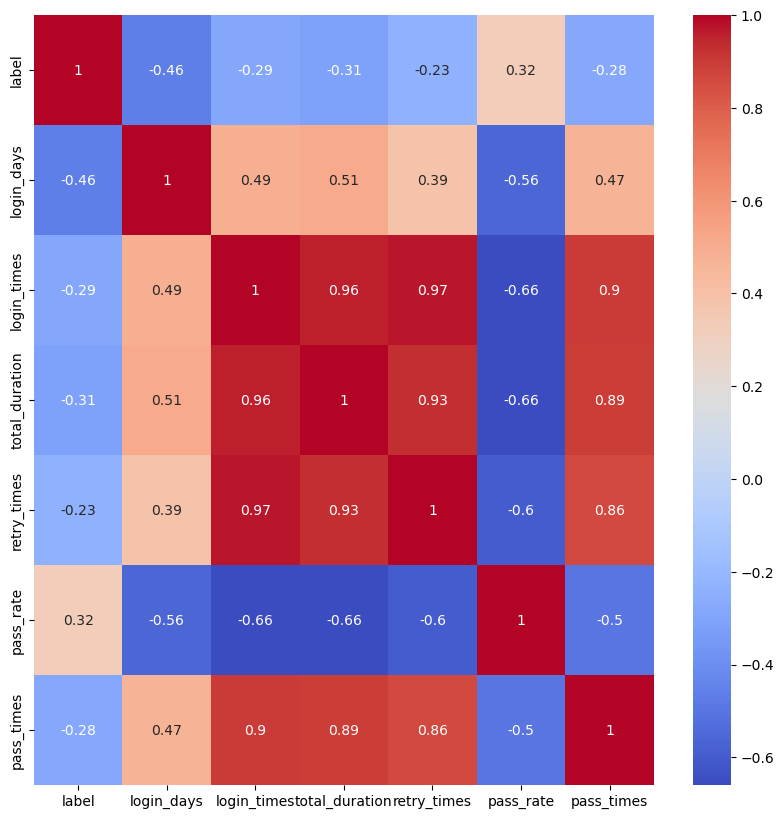

In [161]:
# 热力图

import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 10))
sns.heatmap(train_with_data.corr().round(2), annot=True, cmap='coolwarm')

由热力图可以看出，登录天数、登录次数、游戏时长、重试关卡次数、通过次数与流失呈现负相关，流失=1符合预期。
通过率越高越容易流失有点不符合直觉。表现出来玩家重试次数越多越容易留下来继续游戏，感觉是挑战性更容易留住用户

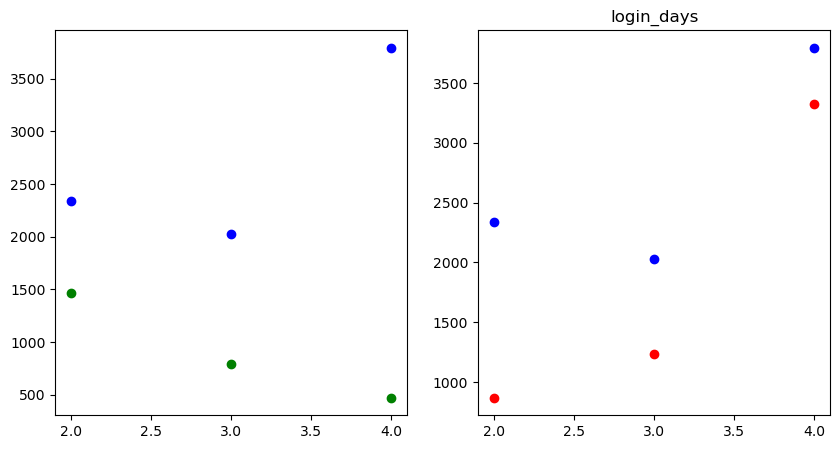

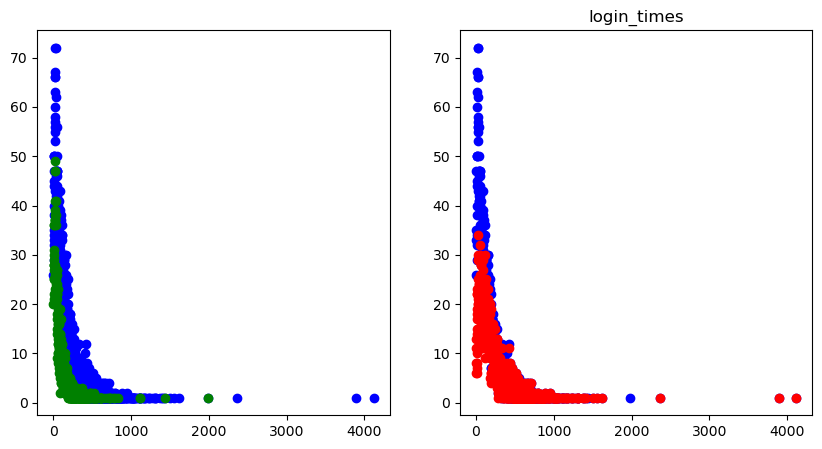

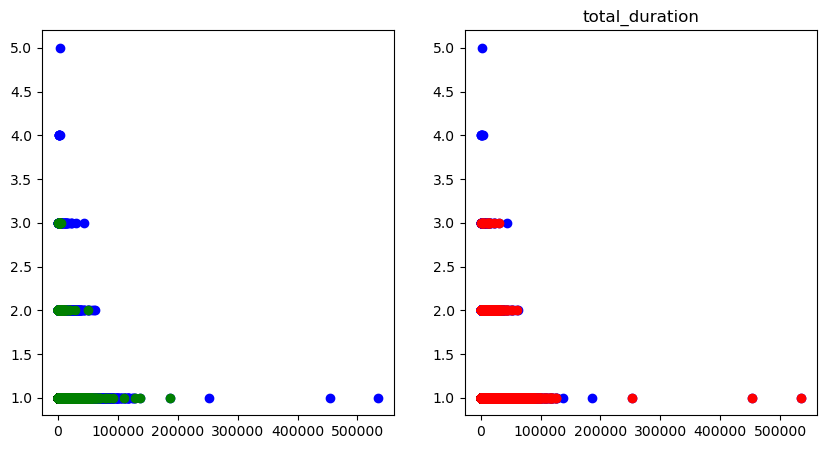

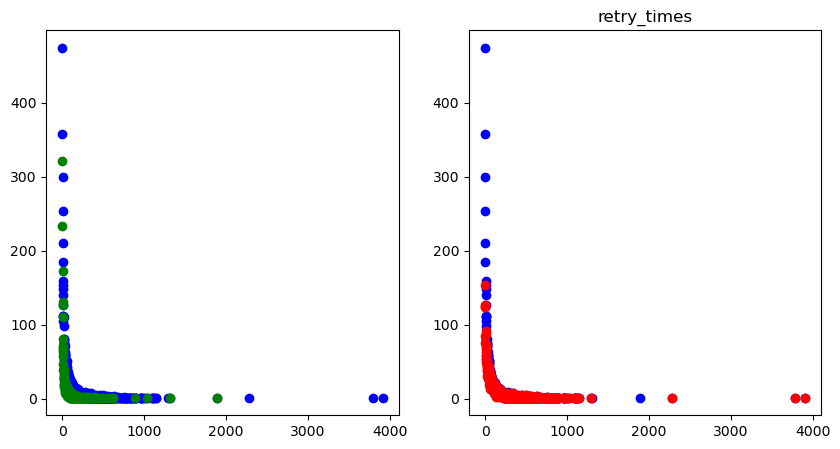

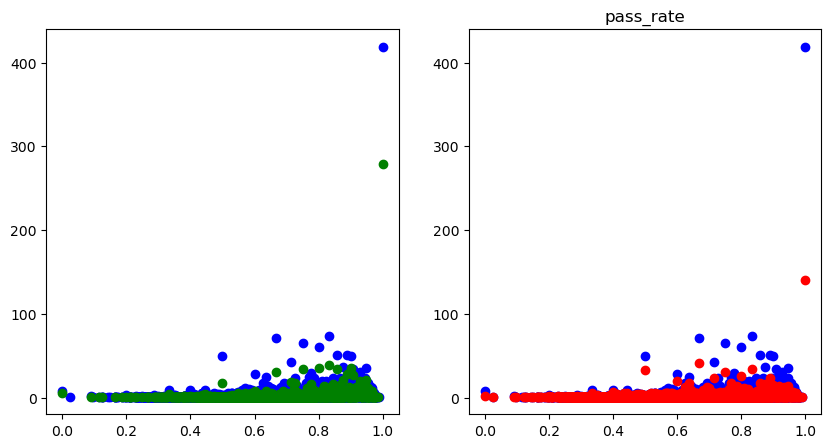

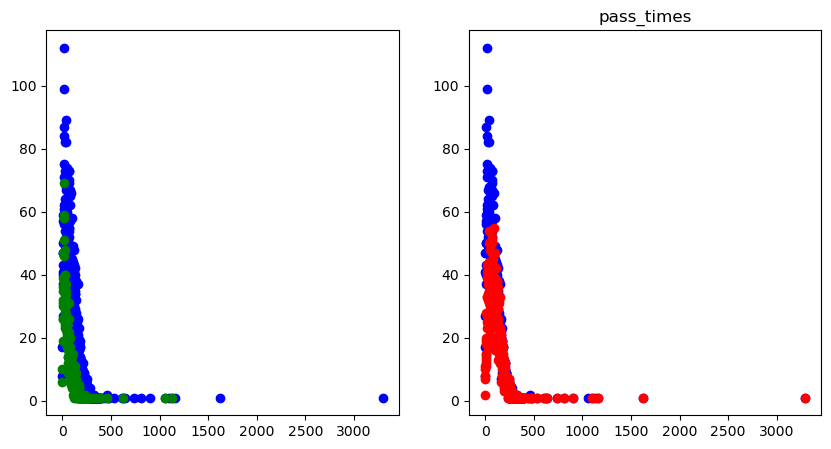

In [162]:
# 特征分布
from collections import Counter

for column in train_with_data.drop(columns=['label']).columns:
    all = Counter(train_with_data[column])
    true_cases = Counter(train_with_data[train_with_data['label'] == 1][column])
    false_cases = Counter(train_with_data[train_with_data['label'] == 0][column].fillna(0))
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(all.keys(), all.values(), color='blue')
    plt.scatter(true_cases.keys(), true_cases.values(), color='green')
    plt.subplot(122)
    plt.scatter(all.keys(), all.values(), color='blue')
    plt.scatter(false_cases.keys(), false_cases.values(), color='red')
    plt.title(column)
    plt.show()

 ### 6.3 使用不同模型训练与测试

 先简单试一下集成学习的，集合svm、决策树、贝叶斯学习方法。

In [163]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 数据归一化
scaler = MinMaxScaler()

train_x = np.array(scaler.fit_transform(train_X))
dev_x = np.array(scaler.transform(dev_X))
test_x = np.array(scaler.transform(test_X))


In [164]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

RANDOM_SEED = 20250801
classifiers = {
    'LinerSVM': CalibratedClassifierCV(LinearSVC(loss='squared_hinge', dual=False, random_state=RANDOM_SEED)),
    'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_SEED),
    'MultBayes': MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
}


In [165]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier

for name, classifier in classifiers.items():
    bagging_classifier = BaggingClassifier(estimator=classifier, n_estimators=2, random_state=RANDOM_SEED, max_samples=0.6, max_features=0.6, bootstrap=True, bootstrap_features=True, n_jobs=1)
    bagging_classifier.fit(train_X, train_Y)
    dev_pred = bagging_classifier.predict_proba(dev_X)[:, 1]
    print(f'bagging {name} dev_auc: {roc_auc_score(dev_Y, dev_pred)}')
    boosting_classifier = AdaBoostClassifier(estimator=classifier, n_estimators=30, learning_rate=1, random_state=RANDOM_SEED, algorithm='SAMME')
    boosting_classifier.fit(train_X, train_Y)
    dev_pred = boosting_classifier.predict_proba(dev_X)[:, 1]
    print(f'boosting {name} dev_auc: {roc_auc_score(dev_Y, dev_pred)}')

bagging LinerSVM dev_auc: 0.745540748058977
boosting LinerSVM dev_auc: 0.7548357387005017
bagging DecisionTree dev_auc: 0.7007555634446516
boosting DecisionTree dev_auc: 0.7190186455699321
bagging MultBayes dev_auc: 0.6992827800894093
boosting MultBayes dev_auc: 0.7051382230709318


In [166]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

vc = VotingClassifier(estimators=list(classifiers.items()), voting='soft')
vc.fit(train_X, train_Y)
dev_pred = vc.predict_proba(dev_X)[:, 1]
print(f'voting dev_auc: {roc_auc_score(dev_Y, dev_pred)}')

voting dev_auc: 0.7458006881622077


In [167]:
# 随机森林测试AUC

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=RANDOM_SEED)
rf.fit(train_X, train_Y)
rf_prev_dev = rf.predict_proba(dev_X)[:, 1]

print(f'rf_prev_dev_auc: {roc_auc_score(dev_Y, rf_prev_dev)}')


rf_prev_dev_auc: 0.7394411572040679


### 6.4 最终结果

- bagging LinerSVM dev_auc: 0.745540748058977
- boosting LinerSVM dev_auc: 0.7548357387005017
- bagging DecisionTree dev_auc: 0.7007555634446516
- boosting DecisionTree dev_auc: 0.7190186455699321
- bagging MultBayes dev_auc: 0.6992827800894093
- boosting MultBayes dev_auc: 0.7051382230709318
- voting dev_auc: 0.7458006881622077
- rf_prev_dev_auc: 0.7394411572040679


根据上面运行结果，最终方案是 boosting LinerSVM。
集成学习相比于单个模型更有优势。整体来看boosting 要比 bagging性能更高，这可能是因为噪声影响较弱，也可能是学习器上较稳定在boosting表现上更优。

In [168]:
result_classifier = AdaBoostClassifier(estimator=classifiers['LinerSVM'], n_estimators=30, learning_rate=1, random_state=RANDOM_SEED, algorithm='SAMME')
result_classifier.fit(train_X, train_Y)
test_pred = result_classifier.predict_proba(test_X)[:, 1]
print(f'result_classifier test_auc: {roc_auc_score(test_Y, test_pred)}')

result_classifier test_auc: 0.7444682000662317
